In [1]:
import sys
sys.path.insert(0, "..")

In [2]:
import pickle 

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
import cobra

from pprint import pp
from molmass import Formula
from cobra.io import read_sbml_model
from experiments.fast_dFBA import ConstantBounds
from utils.cobra_utils import get_or_create_exchange
from parameters.drawdown import *
from plotting.diagnostic import uptakes_and_secretions, plot_pathway, plot_metabolite_fluxes

In [19]:
MODEL_FILE = "../model/Rpom_05.xml"
BIOMASS_ID = "Rpom_hwa_biomass"
DATA_FILE = "../data/clean/CUE2/dFBA.pkl"


# Load and set up model
model = read_sbml_model(MODEL_FILE)

# Set maintenance to 25 mmol/gDW/h
atpm = model.reactions.get_by_id("ATPM")
atpm.bounds = (25, 25)

ex_glc = model.reactions.get_by_id("EX_glc")
ex_ace = get_or_create_exchange(model, "ACET[e]")

# Load condition data
with open(DATA_FILE, "rb") as f:
    data = pickle.load(f)

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot:title={'center':'2.0 millimolar mM Glucose, 0.0 millimolar mM Acetate'}, ylabel='flux (mg / hr)'>)

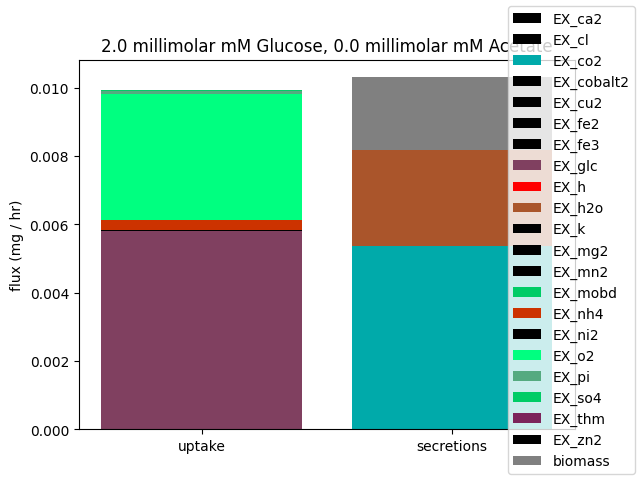

In [20]:
initial_biomass = 0.0001075 # * u("g/L")
initial_glucose = 2.0 * u.mM
initial_acetate = 0.0 * u.mM

with model:
    ex_glc.lower_bound = -3
    # ex_ace.bounds = (0, 0)
    sol = model.optimize()

boundary_ids = [rxn.id for rxn in model.boundary]
boundary_fluxes = sol.fluxes[boundary_ids].reset_index()
boundary_fluxes["fluxes"] = boundary_fluxes["fluxes"] * initial_biomass * CUE_VOLUME.to("L").magnitude  # convert to mmol/hr
boundary_fluxes["Secreting"] = ((np.array([bool(rxn.reactants) for rxn in model.boundary]) & (boundary_fluxes["fluxes"] > 0))
                                | (np.array([bool(rxn.products) for rxn in model.boundary]) & (boundary_fluxes["fluxes"] < 0)))
boundary_fluxes["Mol mass"] = [Formula(list(rxn.metabolites.keys())[0].formula).mass for rxn in model.boundary]

uptakes_and_secretions(model, boundary_fluxes, sol, initial_biomass, CUE_VOLUME, initial_glucose, initial_acetate)

In [21]:
from cobra.flux_analysis.reaction import assess
with model:
    ex_glc.lower_bound = -10
    # ex_ace.bounds = (0, 0)    
    assessment = assess(model, BIOMASS_ID)
    
    if assessment != True:
        print(pp(assessment))
    else:
        print("Passed")

Passed


In [36]:
# Some things can be produced without inputs (when maintenance is off) - find and fix these
with model:
    # Turn off maintenance
    atpm.bounds = (0, 0)

    uhoh = assess(model, BIOMASS_ID)

    print("Precursors ====================================")
    for metabolite, status in uhoh["precursors"].items():
        if status["produced"] != 0:
            print(f"{metabolite}: Produced {status['produced']}")

    print("\nProducts ======================================")
    for metabolite, status in uhoh["products"].items():
        if status["capacity"] != 0:
            print(f"{metabolite}: Produced {status['capacity']}")

Precursors ====================================
PHB-STORAGE[c]: Produced 9.32218916675487e-15
ATP[c]: Produced 1.0959748208474644e-16
NAD[c]: Produced -1.895603493466787e-12
NADP[c]: Produced -6.7060451151855086e-12

Products ======================================


In [43]:
with model:
    atpm.bounds = (0., 0.)
    
    # Add NADP sink
    sink = model.add_boundary(model.metabolites.get_by_id("NADP[c]"), type="demand", reaction_id="NADP_sink", lb=0, ub=1000)
    
    # Set as objective and optimize
    model.objective = sink
    sol = model.optimize()

    print(sink)

NameError: name 'get_components' is not defined

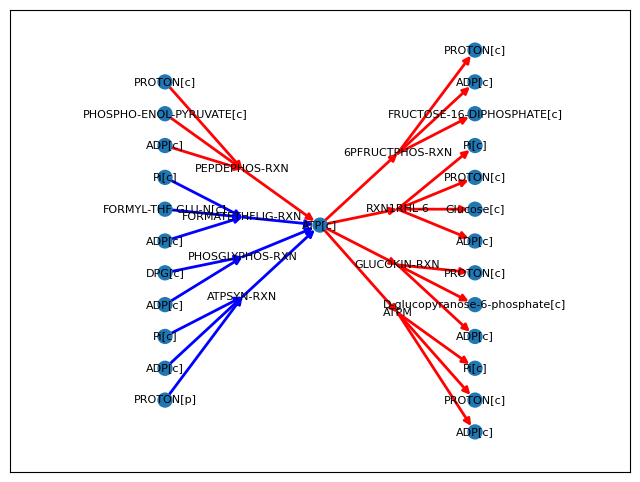

In [32]:
fig, ax = plt.subplots()
with model:
    ex_glc.lower_bound = -10
    model.optimize()
    g, _ = plot_metabolite_fluxes(model,
                                  "ATP[c]",
                                  label_reactions="names",
                                  include_zeros=False,
                                  top_N=8,
                                  ax=ax)

ax.set_xlim(-40, 40)
fig.set_size_inches(8, 6)

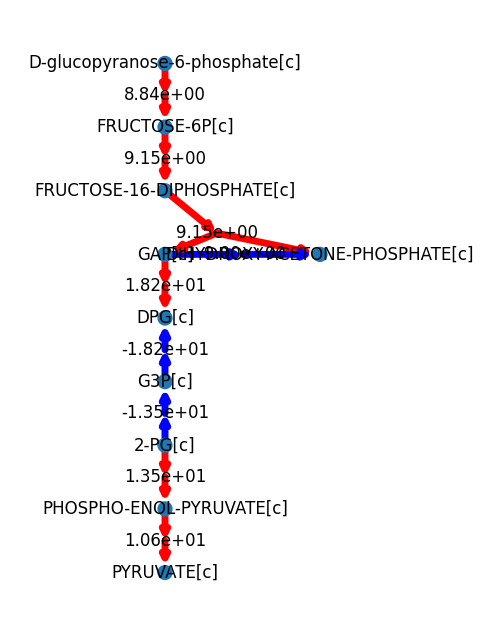

In [10]:
glycolysis = nx.DiGraph()

# Metabolites
glycolysis.add_nodes_from([
    ("D-glucopyranose-6-phosphate[c]", {"pos": (0, 0)}),
    ("FRUCTOSE-6P[c]", {"pos": (0, -10)}),
    ("FRUCTOSE-16-DIPHOSPHATE[c]", {"pos": (0, -20)}),
    ("GAP[c]", {"pos": (0, -30)}),
    ("DIHYDROXY-ACETONE-PHOSPHATE[c]", {"pos": (10, -30)}),
    ("DPG[c]", {"pos": (0, -40)}),
    ("G3P[c]", {"pos": (0, -50)}),
    ("2-PG[c]", {"pos": (0, -60)}),
    ("PHOSPHO-ENOL-PYRUVATE[c]", {"pos": (0, -70)}),
    ("PYRUVATE[c]", {"pos": (0, -80)}),
])

# Reactions
glyc_reactions = ["PGLUCISOM-RXN",
                  "6PFRUCTPHOS-RXN",
                  "F16ALDOLASE-RXN",
                  "TRIOSEPISOMERIZATION-RXN",
                  "GAPOXNPHOSPHN-RXN",
                  "PHOSGLYPHOS-RXN",
                  "3PGAREARR-RXN",
                  "2PGADEHYDRAT-RXN",
                  "PEPDEPHOS-RXN"]

fig, ax = plt.subplots()
plot_pathway(model, glycolysis, glyc_reactions, ax)
ax.set_xlim([-10, 20])
fig.set_size_inches(6,8)

In [11]:
sp = sol.shadow_prices.reset_index()
sp["abs(shadow_price)"] = sp["shadow_prices"].abs()
sp = sp.sort_values("abs(shadow_price)", ascending=False)

lines=100
for i, (_, row) in enumerate(sp.iterrows()):
    if i > lines:
        break
    print(f"{row['index'].ljust(40)}\t{str(row['shadow_prices']).rjust(20)}")

C6[c]                                   	 -2.3074430946727054
C5[c]                                   	 -2.1493453514923786
CPD0-2283[p]                            	 -1.6201752193685919
CPD0-2278[p]                            	 -1.5666049096959191
CPD-9646[c]                             	 -1.4999686708261006
UNDECAPRENYL-DIPHOSPHATE[c]             	  -1.498662077907255
CPD-12258[c]                            	  1.4882093345565002
CPD-12258[p]                            	  1.4869027416376546
CPD-7695[c]                             	 -1.4869027416376546
LIPID[c]                                	  -1.460679403125279
C4[c]                                   	  -1.328804998457328
2-OCTAPRENYL-6-HYDROXYPHENOL[c]         	 -1.2517160162476972
3-OCTAPRENYL-4-HYDROXYBENZOATE[c]       	 -1.2451830516536535
2-OCTAPRENYLPHENOL[c]                   	 -1.2438764587348448
CDPDIACYLGLYCEROL[c]                    	 -1.1328160606391848
cdpdhdecg[c]                            	 -1.1275896889638022
OCTAPREN

In [12]:
sp[sp["shadow_prices"] > 0].sort_values("abs(shadow_price)")

,index,shadow_prices,abs(shadow_price)
641,a-reduced-NrfB-protein[p],3.469447e-18,3.469447e-18
442,CYTIDINE[c],5.637851e-18,5.637851e-18
1018,CPD-3711[c],5.637851e-18,5.637851e-18
1019,CPD-3724[c],5.637851e-18,5.637851e-18
204,L-THREONINE-O-3-PHOSPHATE[c],2.623769e-17,2.623769e-17
...,...,...,...
726,KDO2-PALMITOLEOYL-LIPID-IVA[c],7.003338e-01,7.003338e-01
382,KDO2-LIPID-IVA[p],7.055602e-01,7.055602e-01
676,KDO2-LIPID-IVA[c],7.055602e-01,7.055602e-01
1593,CPD-12258[p],1.486903e+00,1.486903e+00


KeyError: 'RXN-14970-SUC/UBIQUINONE-8//FUM/CPD-9956.31.'

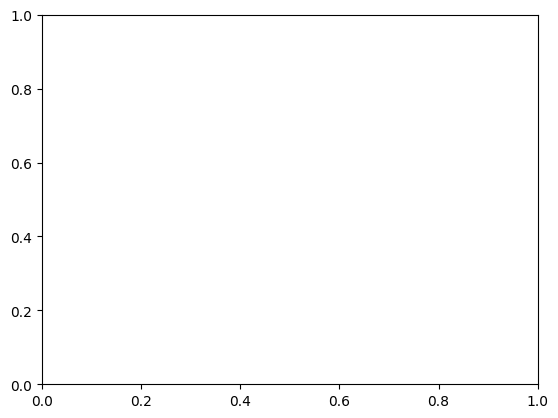

In [13]:
tca = nx.Graph()

# Metabolites
tca.add_nodes_from([
    ("ACETYL-COA[c]", {"pos": (0, 10)}),
    ("CIT[c]", {"pos": (10, -10)}),
    ("CIS-ACONITATE[c]", {"pos": (10, -20)}),
    ("THREO-DS-ISO-CITRATE[c]", {"pos": (10, -30)}),
    ("2-KETOGLUTARATE[c]", {"pos": (10, -40)}),
    ("SUC-COA[c]", {"pos": (-10, -40)}),
    ("SUC[c]", {"pos": (-10, -30)}),
    ("FUM[c]", {"pos": (-10, -20)}),
    ("MAL[c]", {"pos": (-10, -10)}),
    ("OXALACETIC_ACID[c]", {"pos": (-5, 0)}),
])

# Reactions
tca_reactions = ["CITSYN-RXN",
                  "ACONITATEDEHYDR-RXN",
                  "ACONITATEHYDR-RXN",
                  "ISOCITDEH-RXN",
                  "2OXOGLUTARATEDEH-RXN",
                  "SUCCCOASYN-RXN",
                  "RXN-14970-SUC/UBIQUINONE-8//FUM/CPD-9956.31.",
                  "FUMHYDR-RXN",
                  "MALATE-DEH-RXN"]

fig, ax = plt.subplots()
plot_pathway(model, tca, tca_reactions, ax)
ax.set_xlim([-20, 20])
ax.set_ylim([-50, 20])

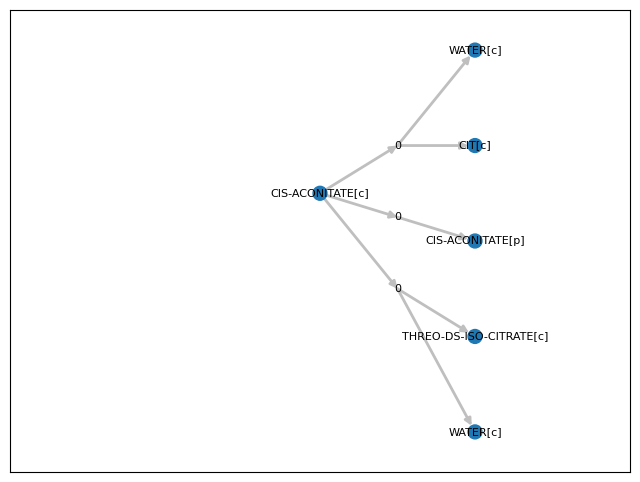

In [11]:
fig, ax = plt.subplots()
g, _ = plot_metabolite_fluxes(model, "CIS-ACONITATE[c]", ax=ax)
ax.set_xlim(-40, 40)
fig.set_size_inches(8, 6)

In [12]:
sol.shadow_prices[sol.shadow_prices < 0].sort_values(ascending=True)

KDO2-LIPID-A[c]                               -2.178577e+00
C6[c]                                         -2.031345e+00
KDO2-LIPID-IVA-COLD[c]                        -2.019842e+00
C5[c]                                         -1.892164e+00
KDO2-LAUROYL-LIPID-IVA[c]                     -1.842704e+00
                                                   ...     
2-HEXAPRENYL-3-METHYL-5-HYDROXY-6-METHOX[c]   -4.313445e-04
CPD-9873[c]                                   -4.313445e-04
CPD-7158[c]                                   -4.313445e-04
CO+2[c]                                       -8.731149e-13
THIAMINE[p]                                   -7.882583e-14
Name: shadow_prices, Length: 1085, dtype: float64

(<networkx.classes.digraph.DiGraph at 0x7f04f23f2740>, <AxesSubplot:>)

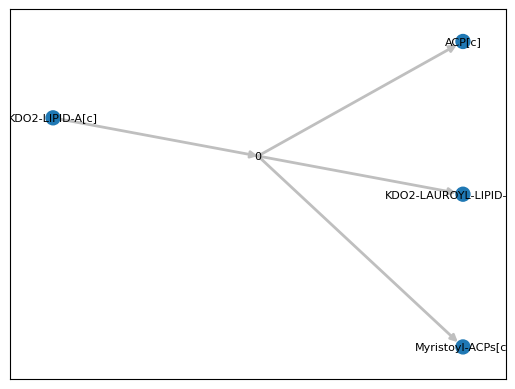

In [13]:
plot_metabolite_fluxes(model, "KDO2-LIPID-A[c]")

(-20.0, 20.0)

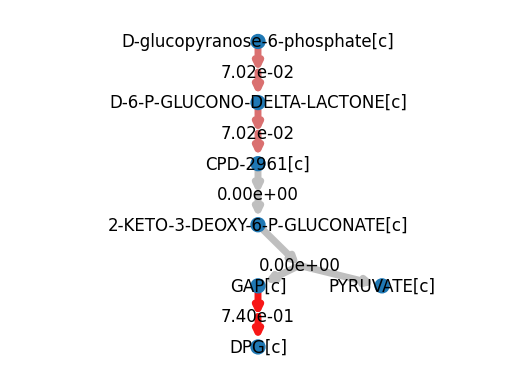

In [14]:
ed = nx.DiGraph()

# Metabolites
ed.add_nodes_from([
    ("D-glucopyranose-6-phosphate[c]", {"pos": (0, 0)}),
    ("D-6-P-GLUCONO-DELTA-LACTONE[c]", {"pos": (0, -10)}),
    ("CPD-2961[c]", {"pos": (0, -20)}),
    ("2-KETO-3-DEOXY-6-P-GLUCONATE[c]", {"pos": (0, -30)}),
    ("GAP[c]", {"pos": (0, -40)}),
    ("PYRUVATE[c]", {"pos": (10, -40)}),
    ("DPG[c]", {"pos": (0, -50)})
])

# Reactions
ed_reactions = ["GLU6PDEHYDROG-RXN",
                  "6PGLUCONOLACT-RXN",
                  "PGLUCONDEHYDRAT-RXN",
                  "KDPGALDOL-RXN",
                  "GAPOXNPHOSPHN-RXN",
                  ]

fig, ax = plt.subplots()
plot_pathway(model, ed, ed_reactions, ax)
ax.set_xlim([-20, 20])

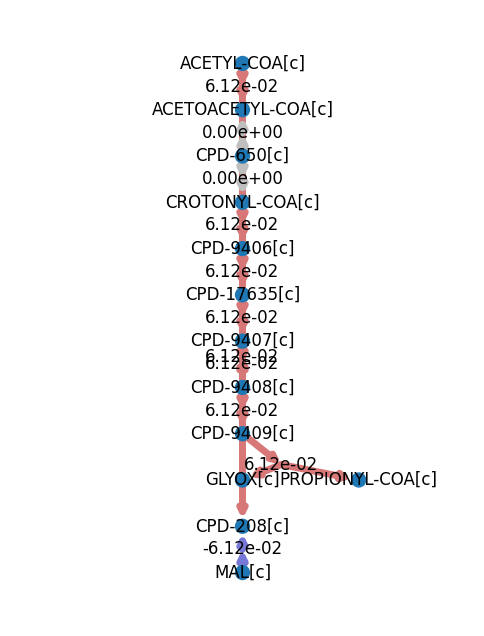

In [15]:
emcoa = nx.DiGraph()

# Metabolites
emcoa.add_nodes_from([
    ("ACETYL-COA[c]", {"pos": (0, 0)}),
    # ("CO-A[c]", {"pos": (10, -10)}),
    ("ACETOACETYL-COA[c]", {"pos": (0, -10)}),
    ("CPD-650[c]", {"pos": (0, -20)}),
    ("CROTONYL-COA[c]", {"pos": (0, -30)}),
    ("CPD-9406[c]", {"pos": (0, -40)}),
    ("CPD-17635[c]", {"pos": (0, -50)}),
    ("CPD-9407[c]", {"pos": (0, -60)}),
    ("CPD-9408[c]", {"pos": (0, -70)}),
    ("CPD-9409[c]", {"pos": (0, -80)}),
    ("PROPIONYL-COA[c]", {"pos": (10, -90)}),
    ("GLYOX[c]", {"pos": (0, -90)}),
    ("CPD-208[c]", {"pos": (0, -100)}),
    ("MAL[c]", {"pos": (0, -110)})
])

# Reactions
emcoa_reactions = ["ACETYL-COA-ACETYLTRANSFER-RXN",
                  "RXN-5901",
                  "3-HYDROXBUTYRYL-COA-DEHYDRATASE-RXN",
                  "RXN-8957",
                  "RXN-16391",
                  "RXN-8958",
                  "RXN-8959",
                  "RXN-8960",
                  "RXN-8961",
                  "MALYL-COA-LYASE-RXN",
                  "MALATE--COA-LIGASE-RXN"
                  ]

fig, ax = plt.subplots()
plot_pathway(model, emcoa, emcoa_reactions, ax)
ax.set_xlim([-20, 20])
fig.set_size_inches(6,8)

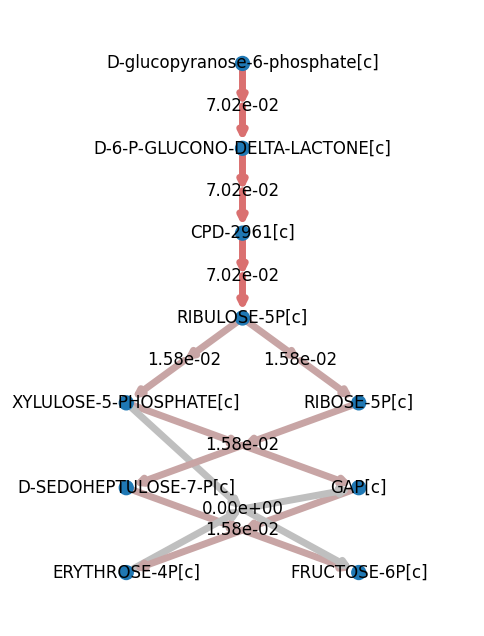

In [16]:
penp = nx.DiGraph()

# Metabolites
penp.add_nodes_from([
    ("D-glucopyranose-6-phosphate[c]", {"pos": (0, 0)}),
    ("D-6-P-GLUCONO-DELTA-LACTONE[c]", {"pos": (0, -10)}),
    ("CPD-2961[c]", {"pos": (0, -20)}),
    ("RIBULOSE-5P[c]", {"pos": (0, -30)}),
    ("XYLULOSE-5-PHOSPHATE[c]", {"pos": (-10, -40)}),
    ("RIBOSE-5P[c]", {"pos": (10, -40)}),
    ("D-SEDOHEPTULOSE-7-P[c]", {"pos": (-10, -50)}),
    ("GAP[c]", {"pos": (10, -50)}),
    ("ERYTHROSE-4P[c]", {"pos": (-10, -60)}),
    ("FRUCTOSE-6P[c]", {"pos": (10, -60)}),
])

# Reactions
penp_reactions = ["GLU6PDEHYDROG-RXN",
                  "6PGLUCONOLACT-RXN",
                  "RXN-9952",
                  "RIBULP3EPIM-RXN",
                  "RIB5PISOM-RXN",
                  "1TRANSKETO-RXN",
                  "TRANSALDOL-RXN",
                  "2TRANSKETO-RXN"]

fig, ax = plt.subplots()
plot_pathway(model, penp, penp_reactions, ax)
ax.set_xlim([-20, 20])
fig.set_size_inches(6, 8)

  1%|          | 17/1688 [00:00<00:35, 47.69it/s]

PROTON[c] : 0.06178273480044994 / 0.04140992244120908 = 1.4919790030557232


 12%|█▏        | 201/1688 [00:04<00:32, 45.35it/s]

CU+2[c] : 0.06178273480045047 / 0.04140992244120908 = 1.491979003055736


 22%|██▏       | 379/1688 [00:08<00:30, 42.29it/s]

CA+2[c] : 0.06178273480045037 / 0.04140992244120908 = 1.4919790030557336


 23%|██▎       | 384/1688 [00:08<00:32, 39.69it/s]

FE+3[c] : 0.061782734800450524 / 0.04140992244120908 = 1.4919790030557374


 86%|████████▌ | 1453/1688 [00:42<00:05, 40.03it/s]

NA+[c] : 0.06178273480045057 / 0.04140992244120908 = 1.4919790030557385


 92%|█████████▏| 1548/1688 [00:44<00:02, 49.84it/s]

NI+2[c] : 0.06178273480045018 / 0.04140992244120908 = 1.491979003055729


100%|██████████| 1688/1688 [00:47<00:00, 35.26it/s]


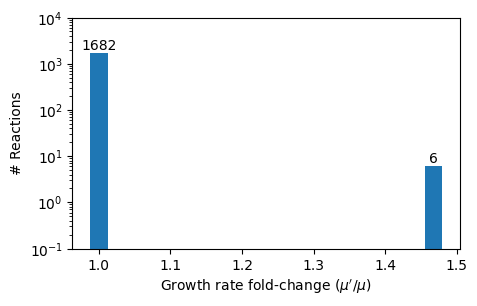

In [17]:
from tqdm import tqdm

baseline = sol.objective_value

fc = np.ones((len(model.metabolites),))
for i, metabolite in enumerate(tqdm(model.metabolites)):
    with model:
        for exchange, bounds in dynamic_medium.items():
            bounds.bound(exchange, substrates[bounds.substrate_id])

        sink = model.add_boundary(metabolite, type="sink")
        sink.bounds = (0,1000)

        mu = model.optimize().objective_value
        fc[i] = mu / baseline
        if abs(fc[i]) > 1.1:
            print(f"{metabolite} : {mu} / {baseline} = {fc[i]}")

fig, ax = plt.subplots()

counts, edges = np.histogram(fc, bins=20)
dx = edges[1] - edges[0]
for count, edge in zip(counts, edges):
    if count == 0:
        continue
    ax.text(edge, 1.2 * count, str(count), horizontalalignment="center")

ax.stairs(counts, edges - dx/2, fill=True)
ax.set_yscale("log")
ax.set_ylabel("# Reactions")
ax.set_xlabel(r"Growth rate fold-change ($\mu'/\mu$)")
ax.set_ylim([0.1, 10000])
fig.set_size_inches(5, 3)

100%|██████████| 1688/1688 [01:31<00:00, 18.40it/s]


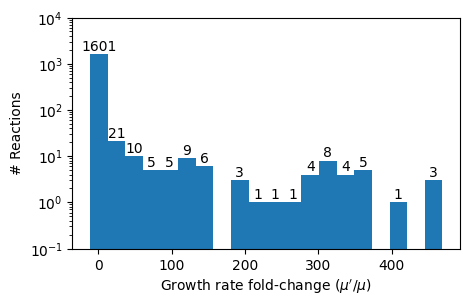

In [18]:
from tqdm import tqdm

baseline = sol.objective_value

fc = np.ones((len(model.metabolites),))
for i, metabolite in enumerate(tqdm(model.metabolites)):
    with model:
        for exchange, bounds in dynamic_medium.items():
            bounds.bound(exchange, substrates[bounds.substrate_id])

        sink = model.add_boundary(metabolite, type="sink")
        sink.bounds = (-1000,0)

        mu = model.optimize().objective_value
        fc[i] = mu / baseline

fig, ax = plt.subplots()

counts, edges = np.histogram(fc, bins=20)
dx = edges[1] - edges[0]
for count, edge in zip(counts, edges):
    if count == 0:
        continue
    ax.text(edge, 1.2 * count, str(count), horizontalalignment="center")

ax.stairs(counts, edges - dx/2, fill=True)
ax.set_yscale("log")
ax.set_ylabel("# Reactions")
ax.set_xlabel(r"Growth rate fold-change ($\mu'/\mu$)")
ax.set_ylim([0.1, 10000])
fig.set_size_inches(5, 3)

In [19]:
diffs = abs(fc - 1)
significant = np.where(diffs > 0.1)[0]

sig = pd.DataFrame({"metabolite" : [model.metabolites[i] for i in significant],
              "fc" : [fc[i] for i in significant]}).sort_values(by="fc", ascending=False)

In [20]:
glycolysis_mets = []
for n in glycolysis.nodes:
    try:
        met = model.metabolites.get_by_id(n)
        glycolysis_mets.append(met.id)
    except:
        continue

sig[[m.id not in glycolysis_mets for m in sig["metabolite"]]][:20]

,metabolite,fc
233,3-P-HYDROXYPYRUVATE[c],426.102421
113,RIBOSE-1P[c],365.150354
166,RIBULOSE-5P[c],365.150354
22,CPD-16551[c],365.150354
20,CPD-15318[c],365.150354
21,CPD-15895[c],365.150354
80,CPD-2961[c],345.570557
27,GLUCOSAMINE-1P[c],322.791676
76,D-GLUCOSAMINE-6-P[c],322.791676
237,GLC-1-P[c],322.791676


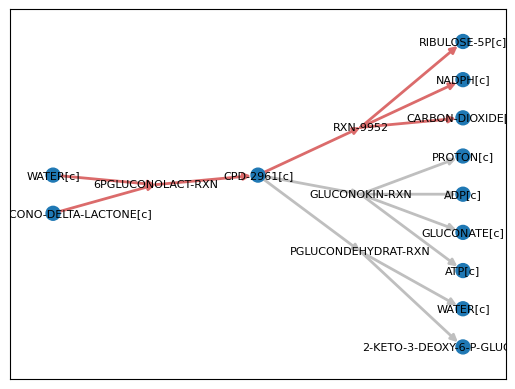

In [21]:
g, _ = plot_metabolite_fluxes(model, "CPD-2961[c]", label_reactions="name")

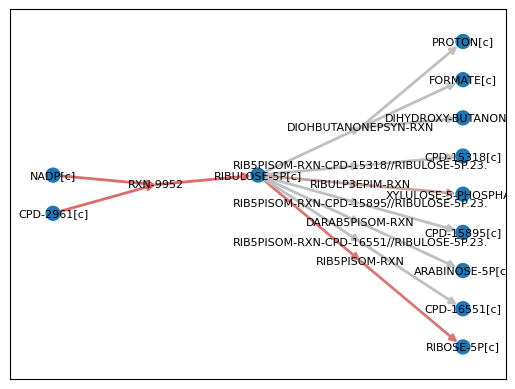

In [22]:
g, _ = plot_metabolite_fluxes(model, "RIBULOSE-5P[c]", label_reactions="name")

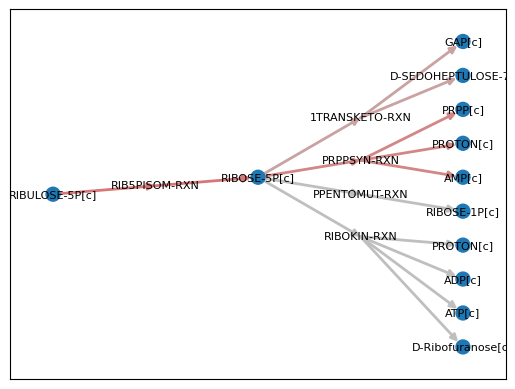

In [23]:
g, _ = plot_metabolite_fluxes(model, "RIBOSE-5P[c]", label_reactions="name")

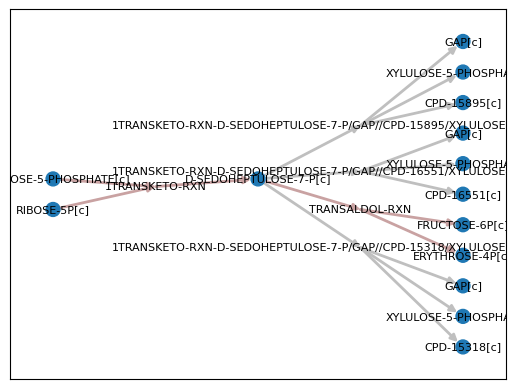

In [24]:
g, _ = plot_metabolite_fluxes(model, "D-SEDOHEPTULOSE-7-P[c]", label_reactions="name")

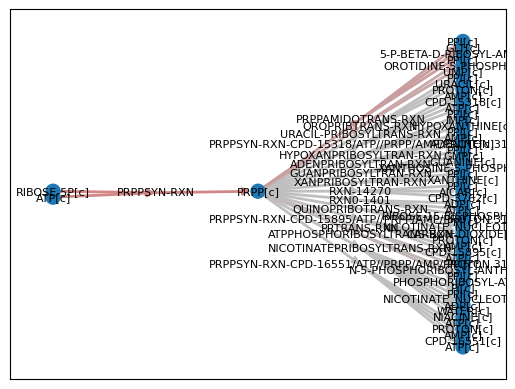

In [25]:
g, _ = plot_metabolite_fluxes(model, "PRPP[c]", label_reactions="name")

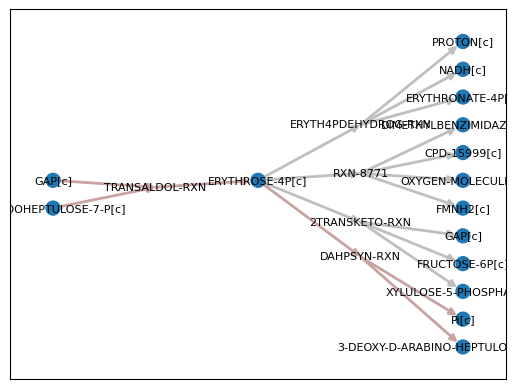

In [26]:
g, _ = plot_metabolite_fluxes(model, "ERYTHROSE-4P[c]", label_reactions="name")

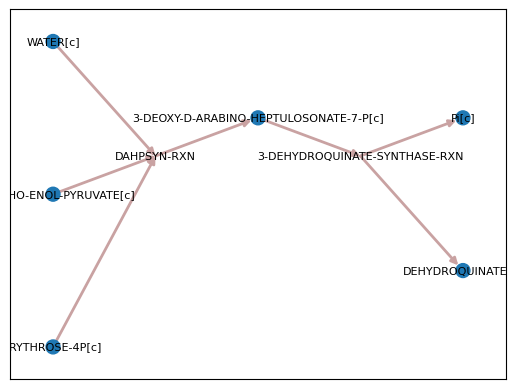

In [27]:
g, _ = plot_metabolite_fluxes(model, "3-DEOXY-D-ARABINO-HEPTULOSONATE-7-P[c]", label_reactions="name")

In [28]:
model.reactions.get_by_id("DAHPSYN-RXN")

Reaction identifier,DAHPSYN-RXN
Name,DAHPSYN-RXN
Memory address,0x7f04f6d4fc10
Stoichiometry,ERYTHROSE-4P[c] + PHOSPHO-ENOL-PYRUVATE[c] + WATER[c] --> 3-DEOXY-D-ARABINO-HEPTULOSONATE-7-P[c] + Pi[c] D-erythrose 4-phosphate + phosphoenolpyruvate + H2O --> 3-deoxy-D-arabino-heptulosonate 7-phosphate + phosphate
GPR,G1G48-1980
Lower bound,0.0
Upper bound,1000.0


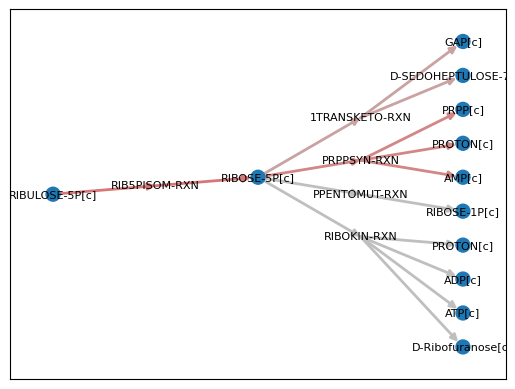

In [29]:
g, _ = plot_metabolite_fluxes(model, "RIBOSE-5P[c]", label_reactions="name")

In [30]:
for rxn in [rxn for rxn in model.reactions if "RXN-15346" in rxn.id]:
    print(f"{rxn.id}\n\t{rxn.reaction}")

RXN-15346
	CPD-16551[c] --> CPD-15895[c]


In [31]:
for rxn in [rxn for rxn in model.reactions if "PPENTOMUT-RXN" in rxn.id]:
    print(f"{rxn.id}\n\t{rxn.reaction}")

D-PPENTOMUT-RXN
	DEOXY-D-RIBOSE-1-PHOSPHATE[c] --> DEOXY-RIBOSE-5P[c]
PPENTOMUT-RXN
	RIBOSE-1P[c] --> RIBOSE-5P[c]
PPENTOMUT-RXN-RIBOSE-1P//CPD-15318.21.
	RIBOSE-1P[c] <=> CPD-15318[c]
PPENTOMUT-RXN-RIBOSE-1P//CPD-15895.21.
	RIBOSE-1P[c] <=> CPD-15895[c]
PPENTOMUT-RXN-RIBOSE-1P//CPD-16551.21.
	RIBOSE-1P[c] <=> CPD-16551[c]


In [32]:
model.reactions.get_by_id("RXN-15345")

Reaction identifier,RXN-15345
Name,RXN-15345
Memory address,0x7f04f6899f00
Stoichiometry,CPD-15318[c] --> CPD-16551[c] alpha-D-ribose 5-phosphate --> beta-D-ribose 5-phosphate
GPR,
Lower bound,0.0
Upper bound,1000.0


In [33]:
[g.nodes[n]["name"] for n in g.neighbors(0)]

['RIBOKIN-RXN', 'PPENTOMUT-RXN', 'PRPPSYN-RXN', '1TRANSKETO-RXN']